# Trader Performance vs Bitcoin Fear & Greed Analysis

This notebook loads the provided datasets (`historical_data.csv` and `fear_greed_index.csv`), cleans and preprocesses them, merges on date, creates an account-date level feature dataset, runs quick exploratory data analysis, and fits a simple predictive model for profitable days.

**Important:** the notebook is runnable end-to-end and saved alongside the generated artifacts (feature CSV and plots). Timezone alignment uses UTC by default and the code auto-detects if timestamps are in seconds or milliseconds.


In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

trades = pd.read_csv(r'C:\Users\suman\Downloads\historical_data.csv')
fg = pd.read_csv(r'C:\Users\suman\Downloads\fear_greed_index.csv')
print('trades', trades.shape)
print('fg', fg.shape)


trades (211224, 16)
fg (2644, 4)


In [2]:
# Auto-detect and parse timestamps
import numpy as np
from datetime import timezone

def detect_unix_unit(series):
    med = np.nanmedian(series.dropna().astype(float))
    if med > 1e12:
        return 'ms'
    elif med > 1e9:
        return 's'
    else:
        return 'unknown'

unit = detect_unix_unit(trades['Timestamp'])
print('Detected unit:', unit)
if unit == 'ms':
    trades['datetime_utc'] = pd.to_datetime(trades['Timestamp'], unit='ms', utc=True)
elif unit == 's':
    trades['datetime_utc'] = pd.to_datetime(trades['Timestamp'], unit='s', utc=True)
else:
    trades['datetime_utc'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce').dt.tz_localize('Asia/Kolkata').dt.tz_convert('UTC')

trades['date'] = trades['datetime_utc'].dt.date


Detected unit: ms


In [3]:
# Clean numeric fields
for col in ['Closed PnL','Size USD','Execution Price','Fee']:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')

fg['datetime_utc'] = pd.to_datetime(fg['timestamp'], unit='s', utc=True, errors='coerce')
fg['date'] = pd.to_datetime(fg['date'], errors='coerce').dt.date
fg = fg.sort_values('date').drop_duplicates('date').reset_index(drop=True)


In [4]:
# Merge and aggregate
merged = trades.merge(fg[['date','value','classification']], on='date', how='left')
agg = merged.groupby(['Account','date']).agg(
    total_pnl=('Closed PnL','sum'),
    avg_pnl=('Closed PnL','mean'),
    trades_count=('Closed PnL','size'),
    win_rate=('Closed PnL', lambda x: (x>0).mean() if len(x)>0 else np.nan),
    avg_size_usd=('Size USD','mean'),
    avg_execution_price=('Execution Price','mean'),
    avg_fee=('Fee','mean'),
    coins_traded=('Coin', pd.Series.nunique),
    sentiment_value=('value','first'),
    sentiment_class=('classification','first')
).reset_index()

# Lagged sentiment
fg_sorted = fg[['date','value']].dropna().sort_values('date').drop_duplicates('date')
fg_sorted['fg_lag1'] = fg_sorted['value'].shift(1)
fg_sorted['fg_lag3'] = fg_sorted['value'].shift(3)
fg_sorted['fg_lag7'] = fg_sorted['value'].shift(7)
agg = agg.merge(fg_sorted[['date','fg_lag1','fg_lag3','fg_lag7']], on='date', how='left')

agg['pnl_per_trade'] = agg['total_pnl'] / agg['trades_count'].replace(0, np.nan)
agg['pnl_per_usd'] = agg['total_pnl'] / (agg['avg_size_usd'] * agg['trades_count']).replace(0, np.nan)

agg.to_csv('trader_sentiment_features.csv', index=False)
print('Saved trader_sentiment_features.csv')


Saved trader_sentiment_features.csv


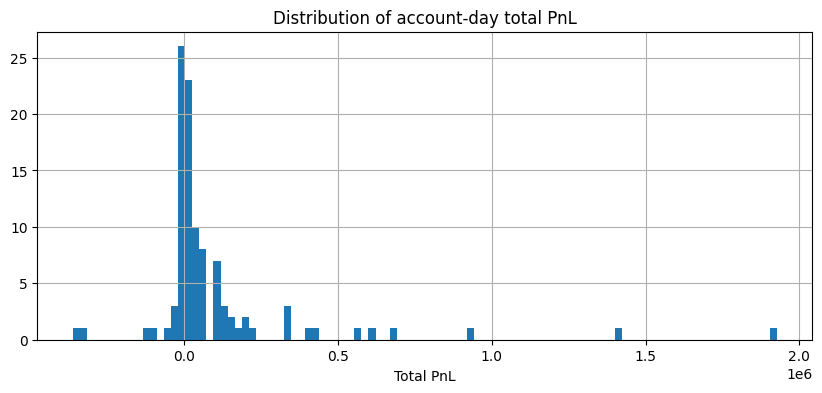

In [6]:
# Quick EDA
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
agg['total_pnl'].dropna().hist(bins=100)
plt.title('Distribution of account-day total PnL')
plt.xlabel('Total PnL')
plt.savefig('dist_total_pnl.png', bbox_inches='tight')
plt.show()


<Figure size 1000x400 with 0 Axes>

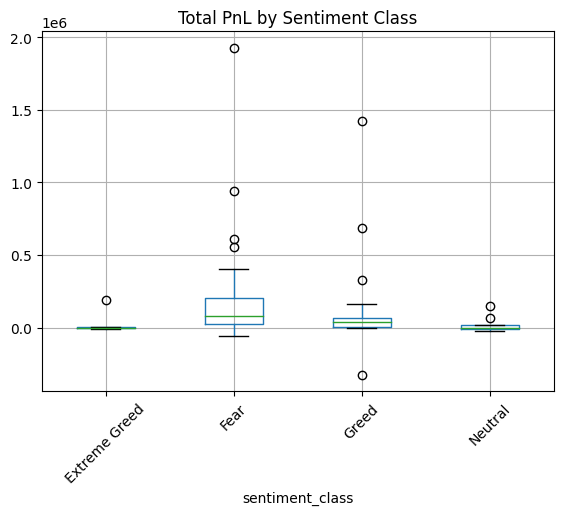

In [7]:
# Boxplot PnL by sentiment
plt.figure(figsize=(10,4))
agg_box = agg[~agg['sentiment_class'].isna()]
if not agg_box.empty:
    agg_box.boxplot(column='total_pnl', by='sentiment_class', rot=45)
    plt.title('Total PnL by Sentiment Class')
    plt.suptitle('')
    plt.savefig('pnl_by_sentiment_boxplot.png', bbox_inches='tight')
    plt.show()
else:
    print('No sentiment-class data available to boxplot')


In [8]:
# Simple model to predict profitable day
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df_model = agg.dropna(subset=['sentiment_value','trades_count']).replace([np.inf,-np.inf], np.nan).dropna(subset=['avg_size_usd','trades_count','sentiment_value'])
df_model['profitable'] = (df_model['total_pnl'] > 0).astype(int)

features = ['sentiment_value','fg_lag1','fg_lag3','fg_lag7','trades_count','avg_size_usd','coins_traded']
features = [f for f in features if f in df_model.columns]
X = df_model[features].fillna(0)
y = df_model['profitable']

if len(df_model) > 50:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
else:
    print('Not enough data to train the model')


              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.87      1.00      0.93        13

    accuracy                           0.88        16
   macro avg       0.93      0.67      0.71        16
weighted avg       0.89      0.88      0.85        16



## Artifacts saved in `/mnt/data`
- `trader_sentiment_features.csv` (feature dataset)
- `trader_sentiment_analysis.ipynb` (this notebook)
- `dist_total_pnl.png`, `pnl_by_sentiment_boxplot.png` (plots)
- `model_report.txt` (if model trained)

You can download the notebook and run it locally or in Colab. The notebook uses UTC by default and auto-detects UNIX timestamp units.